In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from diproperm.DiProPerm import DiProPerm

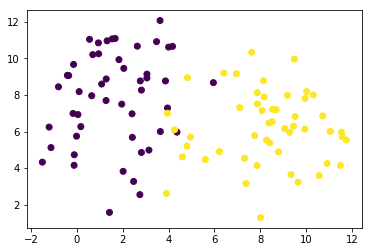

In [2]:
X, y = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=2, random_state=20)
plt.scatter(X[:, 0], X[:, 1], c=y)

In [3]:
# fit DiProPerm using mean difference classifier
# compute md, t and auc summary statistics
# sample 1000 permutations
dpp = DiProPerm(B=1000, stat=['md', 't', 'auc'], clf='md')
dpp.fit(X, y)

Two class DiProPerm of 0 vs. 1 
md: {'obs': 6.811364163879696, 'pval': 0.0, 'Z': 14.227111204131672, 'rejected': True, 'cutoff_val': 1.6161749380065369}
t: {'obs': 18.033513549658643, 'pval': 0.0, 'Z': 27.607973580166085, 'rejected': True, 'cutoff_val': 2.3154794122123485}
auc: {'obs': 0.996, 'pval': 0.0, 'Z': 12.320425468058543, 'rejected': True, 'cutoff_val': 0.6295999999999999}

In [4]:
# the results are stored in dpp.results[STAT] where STAT is the desired summary statistic
print('DiProPerm using md statistic')
print(dpp.results['md'])

print('\nDiProPerm using t statistic')
print(dpp.results['t'])

print('\nDiProPerm using auc statistic')
print(dpp.results['auc'])

DiProPerm using md statistic
{'obs': 6.811364163879696, 'pval': 0.0, 'Z': 14.227111204131672, 'rejected': True, 'cutoff_val': 1.6161749380065369}

DiProPerm using t statistic
{'obs': 18.033513549658643, 'pval': 0.0, 'Z': 27.607973580166085, 'rejected': True, 'cutoff_val': 2.3154794122123485}

DiProPerm using auc statistic
{'obs': 0.996, 'pval': 0.0, 'Z': 12.320425468058543, 'rejected': True, 'cutoff_val': 0.6295999999999999}


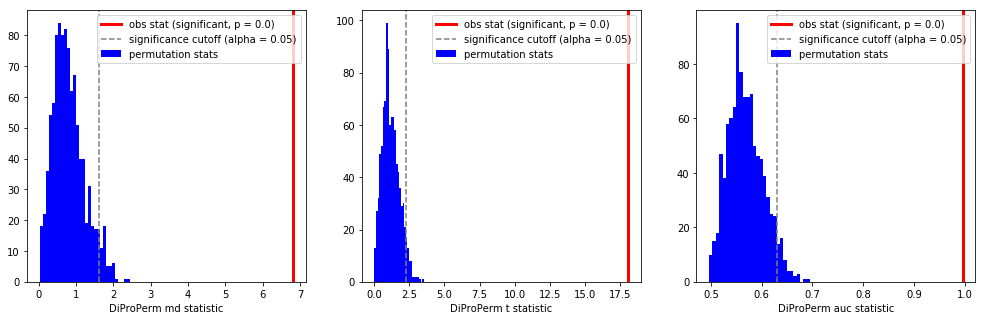

In [5]:
# show histogram of summary statistics
plt.figure(figsize=[17, 5])
plt.subplot(1, 3, 1)
dpp.hist('md')
plt.subplot(1, 3, 2)
dpp.hist('t')
plt.subplot(1, 3, 3)
dpp.hist('auc')

## custom linear classifiers
The `clf` argument can take a function which takes (X, y) data and returns scores (where scores = Xw, w = classification normal vector).

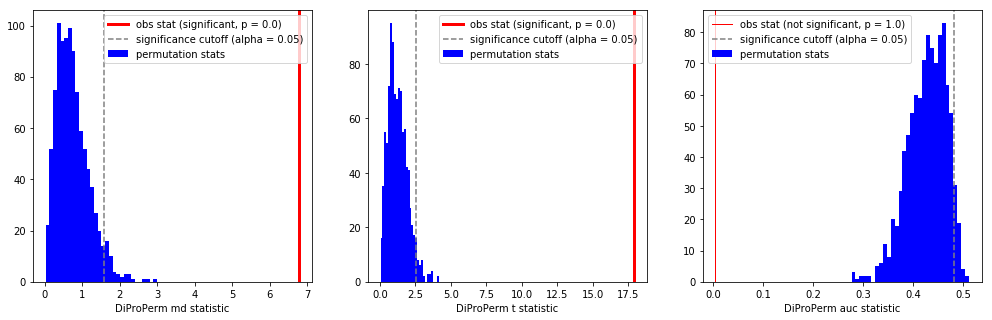

In [6]:
from diproperm.classifiers import get_training_fun
from sklearn.svm import LinearSVC

# clf fits an SVM, selecting C using 5 fold cross-validation, then returns the scores
# of the training data
clf = get_training_fun(clf=LinearSVC(max_iter=10000),  # max_iter set only to suppress annoying warning messages
                       param_grid={'C': [.0001, .001, .01, 1, 10, 100]},  # C grid to cross-validate over
                       metric='roc_auc', n_splits=5)

dpp = DiProPerm(B=1000, stat=['md', 't', 'auc'], clf=clf)
dpp.fit(X, y)

plt.figure(figsize=[17, 5])
plt.subplot(1, 3, 1)
dpp.hist('md')
plt.subplot(1, 3, 2)
dpp.hist('t')
plt.subplot(1, 3, 3)
dpp.hist('auc')

In [7]:
# the clf object above is a function which takes an X, y input,
# trains SVM using 5 fold cross-valdiation, then returns the
# sores of the training data
print(clf(X, y))

[ 0.6954724   3.88182039  9.02440224  4.85786684  4.39656766  1.30541381
  1.71627347 -2.38367367  0.55260965 -1.61506187 -1.24599955  5.87334594
  8.10413812  1.39019269  7.2144306   5.77946447  6.76860976  1.12119485
  7.68346801  2.89212702 -2.51127507  3.92226606 -1.43388183  8.86569427
  4.32688795 -1.84120608 -1.61045683  3.66829055 -3.13111885  1.53742685
  9.12490193 -3.22339706 -3.44978931  0.4048115  -3.28118713  7.17541865
 -2.59473814  1.42144693  8.54768469  0.48234562 -2.16043741  9.56220143
  9.3618637  -2.56780841  1.79346268  5.50002134  2.88643641  5.21646728
  6.25448371 -1.92103597 -2.99524001  2.23391689 -2.06754913  5.47884494
  7.460901    5.9768471  -0.90404567 -2.69657026  5.94029518  5.06669897
  2.86887637  6.87870139  0.04645754  6.93492485 -0.18844961  6.61090291
 -0.53478807  8.97845685  0.06024626 -3.21603175 -1.83137117  5.37014262
 -1.42685227 -1.71418452  5.97804006  2.87317557  2.87675892  0.84826619
 -1.07436482  7.96621992  5.80670564 -1.95198669  6

In [8]:
# for details see diproperm.classifiers.py
print(clf.__doc__)


        Selects hyper-parameters using cross-validation. Then refits
        using the full data set and returns the classification scores.

        Parameters
        -----------
        X (ndarray): dataset with observations on rows

        y (list): class labels

        Output
        -----
        let w = normalized classification vector; returns the
        training data scores (i.e. projection onto normal vector)
        which are given by s = Xw
        


## parallel processing

In [10]:
# sample DiProPerm not in parallel 
%time dpp = DiProPerm(B=10000, stat=['md', 't', 'auc']).fit(X, y)

# sample permutation in parallel using all available cores
%time dpp = DiProPerm(B=10000, stat=['md', 't', 'auc'], n_jobs=-1).fit(X, y)

CPU times: user 11.7 s, sys: 19.5 ms, total: 11.7 s
Wall time: 11.7 s
CPU times: user 374 ms, sys: 25 ms, total: 399 ms
Wall time: 3.08 s
